In [1]:
import numpy as np
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
import pandas as pd
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot
import plotly.graph_objects as go
import math
import seaborn as sns
from sklearn.metrics import mean_squared_error

np.random.seed(1)
tf.random.set_seed(1)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, Dropout, RepeatVector, TimeDistributed
from keras import backend

MODELFILENAME = 'MODELS/LSTM_7d_TFM_2c'
TIME_STEPS=864 #6d

CMODEL = LSTM
UNITS=45
DROPOUT1=0.118
DROPOUT2=0.243
ACTIVATION='tanh'
OPTIMIZER='adadelta'

EPOCHS=43
BATCHSIZE=30
VALIDATIONSPLIT=0.2

## Càrrega de les dades

In [2]:
# Code to read csv file into Colaboratory:
# from google.colab import files
# uploaded = files.upload()
# import io
# df = pd.read_csv(io.BytesIO(uploaded['SentDATA.csv']))
# Dataset is now stored in a Pandas Dataframe
df = pd.read_csv('../../data/dadesTFM.csv')

df.reset_index(inplace=True)
df['Time'] = pd.to_datetime(df['Time'])
df = df.set_index('Time')

## Transformació de dades

In [3]:
columns = ['PM1','PM25','PM10','PM1ATM','PM25ATM','PM10ATM']

df1 = df.copy();

df1 = df1.rename(columns={"PM 1":"PM1","PM 2.5":"PM25","PM 10":"PM10","PM 1 ATM":"PM1ATM","PM 2.5 ATM":"PM25ATM","PM 10 ATM":"PM10ATM"})

df1['PM1'] = df['PM 1'].astype(np.float32)
df1['PM25'] = df['PM 2.5'].astype(np.float32)
df1['PM10'] = df['PM 10'].astype(np.float32)
df1['PM1ATM'] = df['PM 1 ATM'].astype(np.float32)
df1['PM25ATM'] = df['PM 2.5 ATM'].astype(np.float32)
df1['PM10ATM'] = df['PM 10 ATM'].astype(np.float32)

In [4]:
df2 = df1.copy()

## Crear dades d'entrenament i de test

In [5]:
train_size = int(len(df2) * 0.8)
test_size = len(df2) - train_size
train, test = df2.iloc[0:train_size], df2.iloc[train_size:len(df2)]
train.shape, test.shape

((3117, 7), (780, 7))

## Normalitzar les dades d'entrenament

In [6]:
#Standardize the data
for col in columns:
    scaler = StandardScaler()
    train[col] = scaler.fit_transform(train[[col]])

<ipython-input-6-83cecdbc25f8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[col] = scaler.fit_transform(train[[col]])
<ipython-input-6-83cecdbc25f8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[col] = scaler.fit_transform(train[[col]])
<ipython-input-6-83cecdbc25f8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

## Crear finestra de temps

In [7]:
def create_sequences(X, y, time_steps=TIME_STEPS):
    Xs, ys = [], []
    for i in range(len(X)-time_steps):
        Xs.append(X.iloc[i:(i+time_steps)].values)
        ys.append(y.iloc[i+time_steps])
    
    return np.array(Xs), np.array(ys)

X_train, y_train = create_sequences(train[[columns[1]]], train[columns[1]])
#X_test, y_test = create_sequences(test[[columns[1]]], test[columns[1]])

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')

X_train shape: (2253, 864, 1)
y_train shape: (2253,)


## Creació del model

In [8]:
#afegir nova mètrica
def rmse(y_true, y_pred):
	return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

In [9]:
model = Sequential()
model.add(CMODEL(units = UNITS, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(rate=DROPOUT1))
model.add(CMODEL(units = UNITS, return_sequences=True))
model.add(Dropout(rate=DROPOUT2))
model.add(TimeDistributed(Dense(1,kernel_initializer='normal',activation=ACTIVATION)))
model.compile(optimizer=OPTIMIZER, loss='mae',metrics=['mse',rmse])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 864, 45)           8460      
_________________________________________________________________
dropout (Dropout)            (None, 864, 45)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 864, 45)           16380     
_________________________________________________________________
dropout_1 (Dropout)          (None, 864, 45)           0         
_________________________________________________________________
time_distributed (TimeDistri (None, 864, 1)            46        
Total params: 24,886
Trainable params: 24,886
Non-trainable params: 0
_________________________________________________________________


In [10]:
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCHSIZE, validation_split=VALIDATIONSPLIT,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')], shuffle=False)

Epoch 1/43
61/61 [==============================] - 32s 531ms/step - loss: 0.7502 - mse: 0.8660 - rmse: 0.7506 - val_loss: 0.9193 - val_mse: 1.0090 - val_rmse: 0.9194
Epoch 2/43
61/61 [==============================] - 32s 531ms/step - loss: 0.7502 - mse: 0.8660 - rmse: 0.7506 - val_loss: 0.9194 - val_mse: 1.0091 - val_rmse: 0.9195
Epoch 3/43
61/61 [==============================] - 35s 574ms/step - loss: 0.7501 - mse: 0.8660 - rmse: 0.7505 - val_loss: 0.9194 - val_mse: 1.0092 - val_rmse: 0.9195
Epoch 4/43
61/61 [==============================] - 36s 585ms/step - loss: 0.7501 - mse: 0.8660 - rmse: 0.7505 - val_loss: 0.9195 - val_mse: 1.0093 - val_rmse: 0.9196
Epoch 5/43
61/61 [==============================] - 35s 570ms/step - loss: 0.7501 - mse: 0.8660 - rmse: 0.7505 - val_loss: 0.9195 - val_mse: 1.0094 - val_rmse: 0.9196
Epoch 6/43
61/61 [==============================] - 35s 567ms/step - loss: 0.7501 - mse: 0.8660 - rmse: 0.7505 - val_loss: 0.9196 - val_mse: 1.0095 - val_rmse: 0.919

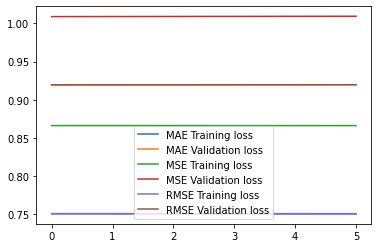

In [11]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='MAE Training loss')
plt.plot(history.history['val_loss'], label='MAE Validation loss')
plt.plot(history.history['mse'], label='MSE Training loss')
plt.plot(history.history['val_mse'], label='MSE Validation loss')
plt.plot(history.history['rmse'], label='RMSE Training loss')
plt.plot(history.history['val_rmse'], label='RMSE Validation loss')
plt.legend();

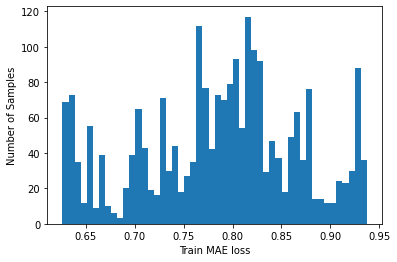

In [12]:
X_train_pred = model.predict(X_train, verbose=0)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel('Train MAE loss')
plt.ylabel('Number of Samples');


## Validació del model

In [13]:
def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()

    print(model_name + ':')
    print('Mean Absolute Error: {:.4f}'.format(mae))
    print('Root Mean Square Error: {:.4f}'.format(rmse))
    print('Mean Square Error: {:.4f}'.format(mse))
    print('')
    return mae,rmse,mse

In [14]:
mae,rmse,mse = evaluate_prediction(X_train_pred, X_train,"LSTM")

LSTM:
Mean Absolute Error: 0.7864
Root Mean Square Error: 0.9869
Mean Square Error: 0.9739



In [15]:
model.save(MODELFILENAME+'.h5')

## Testejar el model

In [16]:
#càlcul del threshold de test
def calculate_threshold(X_test, X_test_pred):
    distance = np.sqrt(np.mean(np.square(X_test_pred - X_test),axis=1))
    """Sorting the scores/diffs and using a 0.80 as cutoff value to pick the threshold"""
    distance.sort();
    cut_off = int(0.8 * len(distance));
    threshold = distance[cut_off];
    return threshold

In [17]:
for col in columns:
    print ("####################### "+col +" ###########################")

    #Standardize the test data
    scaler = StandardScaler()
    test_cpy = test.copy()
    
    test[col] = scaler.fit_transform(test[[col]])
    
    #creem seqüencia amb finestra temporal per les dades de test
    X_test1, y_test1 = create_sequences(test[[col]], test[col])
    print(f'Testing shape: {X_test1.shape}')
    
    #evaluem el model
    eval = model.evaluate(X_test1, y_test1)
    print("evaluate: ",eval)
    
    #predim el model
    X_test1_pred = model.predict(X_test1, verbose=0)
    
    
    evaluate_prediction(X_test1_pred, X_test1,"LSTM")
    
    #càlcul del mae_loss
    test1_mae_loss = np.mean(np.abs(X_test1_pred - X_test1), axis=1)
    test1_rmse_loss = np.sqrt(np.mean(np.square(X_test1_pred - X_test1),axis=1))

    # reshaping test prediction
    X_test1_predReshape = X_test1_pred.reshape((X_test1_pred.shape[0] * X_test1_pred.shape[1]), X_test1_pred.shape[2])
    
    # reshaping test data
    X_test1Reshape = X_test1.reshape((X_test1.shape[0] * X_test1.shape[1]), X_test1.shape[2])
  
    threshold_test = calculate_threshold(X_test1Reshape,X_test1_predReshape)
    
    test1_score_df = pd.DataFrame(test[TIME_STEPS:])
    test1_score_df['loss'] = test1_rmse_loss.reshape((-1))
    test1_score_df['threshold'] = threshold_test
    test1_score_df['anomaly'] = test1_score_df['loss'] > test1_score_df['threshold']
    test1_score_df[col] = test[TIME_STEPS:][col]

    #gràfic test lost i threshold
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=test1_score_df.index, y=test1_score_df['loss'], name='Test loss'))
    fig.add_trace(go.Scatter(x=test1_score_df.index, y=test1_score_df['threshold'], name='Threshold'))
    fig.update_layout(showlegend=True, title='Test loss vs. Threshold')
    fig.show()
    
    #Posem les anomalies en un array
    anomalies1 = test1_score_df.loc[test1_score_df['anomaly'] == True]
    anomalies1.shape
    print('anomalies: ',anomalies1.shape); print();
   
    #Gràfic dels punts i de les anomalíes amb els valors de dades transformades per verificar que la normalització que s'ha fet no distorssiona les dades
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=test1_score_df.index, y=scaler.inverse_transform(test1_score_df[col]), name=col))
    fig.add_trace(go.Scatter(x=anomalies1.index, y=scaler.inverse_transform(anomalies1[col]), mode='markers', name='Anomaly'))
    fig.update_layout(showlegend=True, title='Detected anomalies')
    fig.show()
    
    print ("######################################################")

####################### PM1 ###########################
Testing shape: (0,)


<ipython-input-17-48420fb1aa44>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[col] = scaler.fit_transform(test[[col]])
c:\python38\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:581: RuntimeWarning: divide by zero encountered in log10
  numdigits = int(np.log10(self.target)) + 1


OverflowError: cannot convert float infinity to integer